# Predicting-Obesity-Rate-Based-on-Food-Environment

## 2. Modelling

## Contents

- [Imports](#Imports)
- [Data Dictionary](#Data-Dictionary)
- [Feature Collinearity](#Feature-Collinearity)
- [Preprocessing](#Preprocessing)
    - [Train/Test Split and Scale](#Train/Test-Split-and-Scale)
- [Regression Metrics Function](#Regression-Metrics-Function)
- [Modelling](#Modelling)
    - [Baseline Model](#Baseline-Model)
    - [Linear Regression with all features](#Linear-Regression-with-all-features)
    - [Random Forest for important features](#Random-Forest-for-important-features)
    - [Linear Regression with Random Forest important features](#Linear-Regression-with-Random-Forest-important-features)
    - [Linear Regression with correlated features](#Linear-Regression-with-correlated-features)
    - [Regularized Linear Regression](#Regularized-Linear-Regression)
        - [Ridge](#Ridge)
        - [Lasso](#Lasso)
        - [Elastic Net](#Elastic-Net)
    - [Random Forest](#Random-Forest)
    - [Adaboost on Random Forest](#Adaboost-on-Random-Forest)
- [Predictions](#Predictions)
    - [Table of results](#Table-of-results)
- [Conclusions and Limitations](#Conclusions-and-Limitations)
- [Sources](#Sources)

## Imports 

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

In [2]:
df = pd.read_csv('../Data/df.csv')

### Data Dictionary

In [3]:
#remove the extra column FIPS column 
df.drop(columns = ['FIPS.1'], inplace=True)

Data Dictionary of the Final merged data frame:

| Name                  | Description                                      |
|-----------------------|--------------------------------------------------|
| PCT_DIABETS_ADULTS08  | Adult diabetes rate in 2008                      |
| PCT_DIABETES_ADULTS13 | Adult Diabetes rate in 2013                      |
| RECFAC09              | Number of fitness facilities                     |
| GROC09                | Count of grocery stores                          |
| SUPERC                | Number of superstores                            |
| SNAPS12               | SNAP-Authorized stores                           |
| WICS12                | WIC-authorized stores                            |
| LACCESS_POP10         | Count of population- low access to store         |
| PCT_LACCESS_POP10     | Percent of population - low access to store      |
| LACCESS_LOWI10        | Low income and low access to store, 2010         |
| PCT_LACCESS_LOWI10    | Percent Low income and low access to store, 2010 |
| LACCESS_HHNV10        | Households, no car & low access to store, 2010   |
| PCT_LACCESS_HHNV10    | Percent of households no car and low access      |
| LACCESS_CHILD10       | Child Low Access to Car                          |
| SNAPSPTH12            | SNAP-authorized stores/1,000 pop                 |
| GHVEG_FARMS07         | Greenhouse vegetable and fresh herb farms        |
| FMRKT09               | Number of Farmer's Markets                       |
| SPECS09               | Number of Specialty Stores                       |
| CONVS09               | Number of Convenience Stores                     |
| PCT_LOCLFARM07        | Farms with direct sales                          |
|                       |                                                  |

### Feature Collinearity

- Which features should be included in the model?
- Feature multicollinearity

First, we checked collinearity among the different features and the percent of obese adults in 2013. We then found the features with collinearity greater than .1 and later will run a linear regression with those features. 

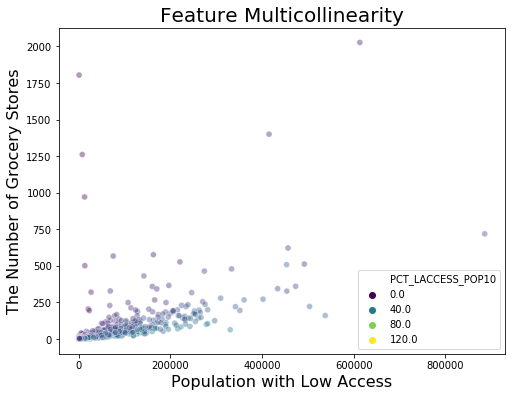

In [4]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['LACCESS_POP10'], y=df['GROC09'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis')
plt.title("Feature Multicollinearity", fontsize=20)
ax.set_xlabel('Population with Low Access', fontsize = 16)
ax.set_ylabel('The Number of Grocery Stores', fontsize = 16);

As the number of people with low access to stores increase, the number of grocery stores increases. We see there are a few outliers that have a few people with low access and a high number of grocery stores. Those outliers are Connecticut, Massachusets, and Delaware with a high number of grocery stores and a low obesity rate. 

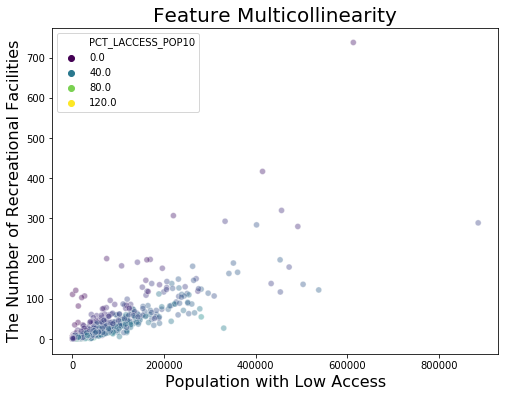

In [5]:
ax = plt.figure(figsize=(8,6))
# added legend of population with low access 
ax = sns.scatterplot(x=df['LACCESS_POP10'], y=df['RECFAC09'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis')
plt.title("Feature Multicollinearity", fontsize=20)
ax.set_xlabel('Population with Low Access', fontsize = 16)
ax.set_ylabel('The Number of Recreational Facilities', fontsize = 16);

This shows the same trend as above with some outliers. Typically, as the number of recreational facilities increases, the population with low access increases. 

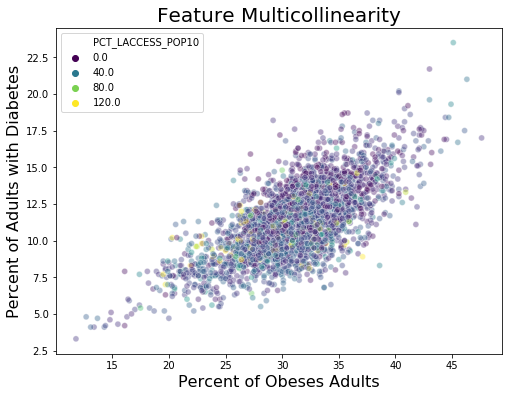

In [6]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['PCT_OBESE_ADULTS13'], y=df['PCT_DIABETES_ADULTS13'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis');

plt.title("Feature Multicollinearity", fontsize=20)
ax.set_xlabel('Percent of Obeses Adults', fontsize = 16)
ax.set_ylabel('Percent of Adults with Diabetes', fontsize = 16);

Not surprising that the diabetes rate for adults is very correlated with obesity rates. Diabetes tends to be a result of obesity. 

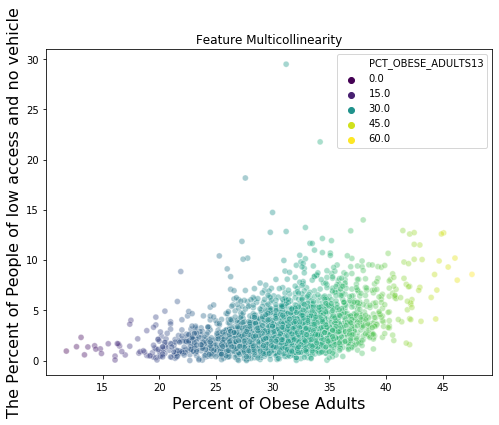

In [7]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['PCT_OBESE_ADULTS13'], y=df['PCT_LACCESS_HHNV10'], hue=df['PCT_OBESE_ADULTS13'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis');
plt.title("Feature Multicollinearity")
ax.set_xlabel('Percent of Obese Adults', fontsize = 16)
ax.set_ylabel('The Percent of People of low access and no vehicle', fontsize = 16);

It makes sense for if the percentage of people with low access and no vehicle then the percent of obese adults will increase. Since they aren't able to access food stores.   

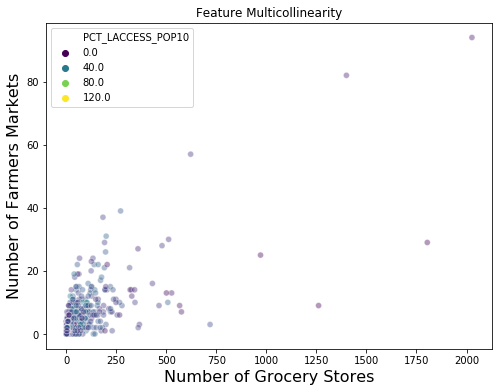

In [8]:
ax = plt.figure(figsize=(8,6))
ax = sns.scatterplot(x=df['GROC09'], y=df['FMRKT09'], hue=df['PCT_LACCESS_POP10'],
                 cmap='viridis', alpha=.4, legend='brief', palette='viridis');


plt.title("Feature Multicollinearity")
ax.set_xlabel('Number of Grocery Stores', fontsize = 16)
ax.set_ylabel('Number of Farmers Markets', fontsize = 16);

There are a few outliers that have a lot of grocery stores and farmers market. The outliers are Connecticut, Massachusetts and Delaware.

In [9]:
correlation = df.corr()[['PCT_OBESE_ADULTS13']].head(10)
sorted_coefs = abs(correlation).sort_values('PCT_OBESE_ADULTS13', ascending = False)
    
strong_corr = sorted_coefs[(sorted_coefs['PCT_OBESE_ADULTS13'] > .1)]

In [10]:
# added height to use in .barh - to add colors to each bar 
height = list(strong_corr['PCT_OBESE_ADULTS13'])

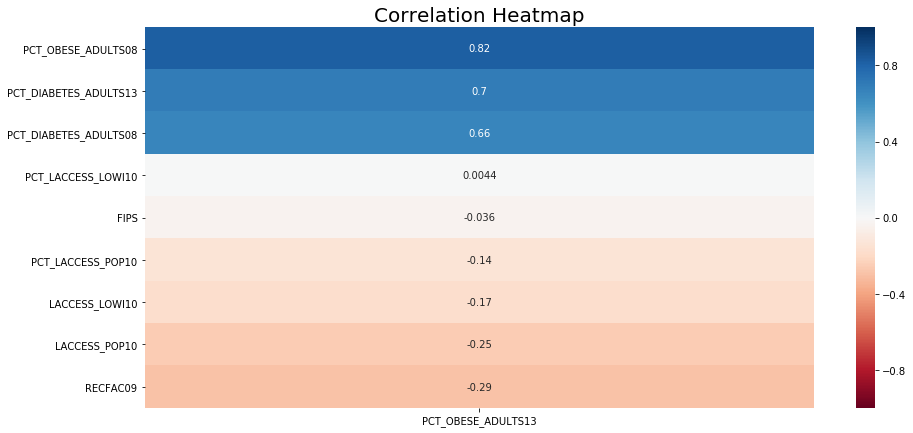

In [11]:
fig, ax = plt.subplots(figsize=(15,7)) 
sns.heatmap(df.corr()[['PCT_OBESE_ADULTS13']].head(10).sort_values('PCT_OBESE_ADULTS13', ascending=False).iloc[1:],
            annot=True, vmin=-1, vmax=1, cmap="RdBu")
plt.title('Correlation Heatmap', fontsize = 20);

The percentage of adults with diabetes have a strong correlation to percent of obese adults, as well as the number of recreactional facilities having a strong negative correlation.

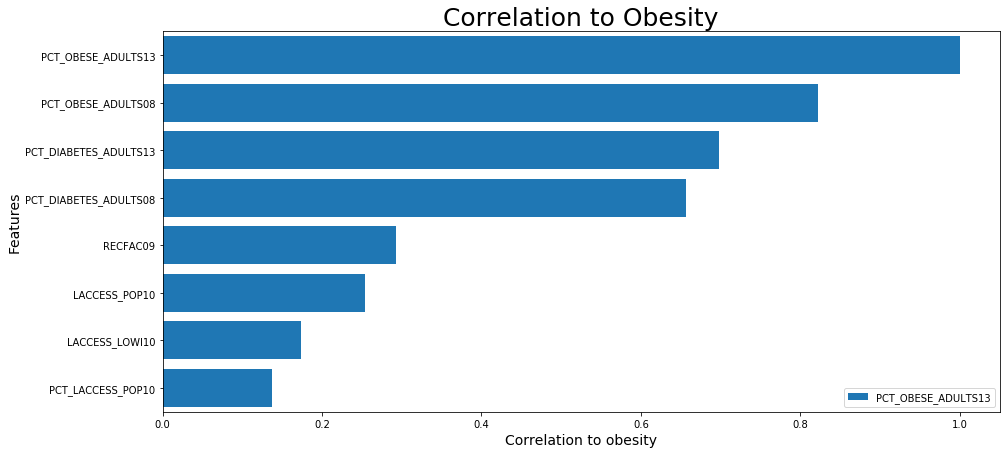

In [12]:
ax = strong_corr.head(15).plot(kind='barh', figsize = (15,7))
ax.set_ylabel('Features', fontsize = 14)
ax.invert_yaxis()
ax.set_xlabel('Correlation to obesity', fontsize = 14)
plt.title('Correlation to Obesity', fontsize = 25)
plt.barh(strong_corr.head(15).index, height);

Low access and low income also highley correlated to obesity.

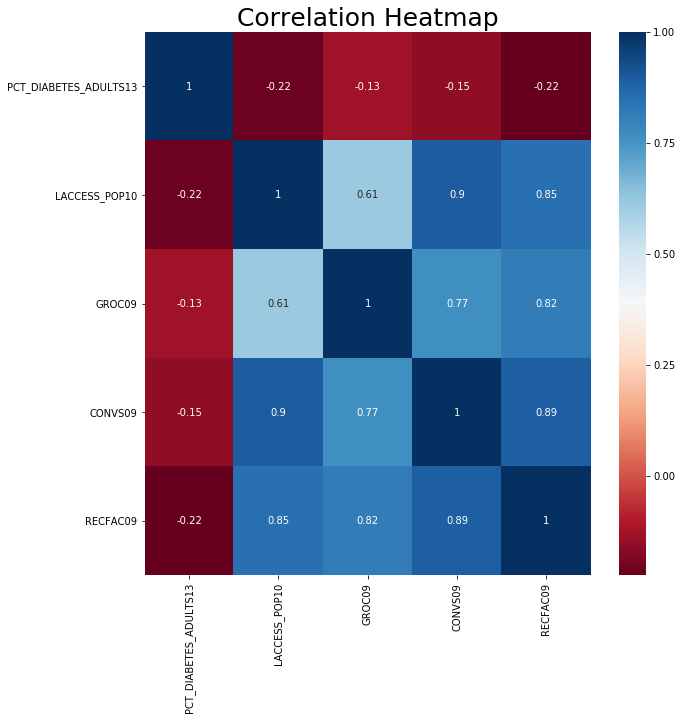

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df[[
    'PCT_DIABETES_ADULTS13', 'LACCESS_POP10','GROC09',
                 'CONVS09', 'RECFAC09']]\
.corr(),
            annot=True, cmap="RdBu")
ax.set_ylim(len(df[[
    'PCT_DIABETES_ADULTS13', 'LACCESS_POP10','GROC09',
                 'CONVS09', 'RECFAC09']]\
.corr())-1, -1)
plt.title('Correlation Heatmap', fontsize = 25);

There is a high correlation between low access and recreation facilities as well as low access and number of convenience stores. Before, running the model we should remove one the features. 

In [14]:
# check for correlation 
corr = df.corr()
corr['PCT_OBESE_ADULTS13'].sort_values(ascending=False).head(10)

PCT_OBESE_ADULTS13       1.000000
PCT_OBESE_ADULTS08       0.821918
PCT_DIABETES_ADULTS13    0.698009
PCT_DIABETES_ADULTS08    0.656896
PCT_LACCESS_HHNV10       0.402890
SNAPSPTH12               0.345473
CONVSPTH09               0.174131
SUPERCPTH09              0.089896
WICSPTH08                0.062218
WICSPTH12                0.044092
Name: PCT_OBESE_ADULTS13, dtype: float64

The access to stores, the number of convenience stores, the number of supercenters and the number WIC-associated stores were correlated with the percent of obese adults. 

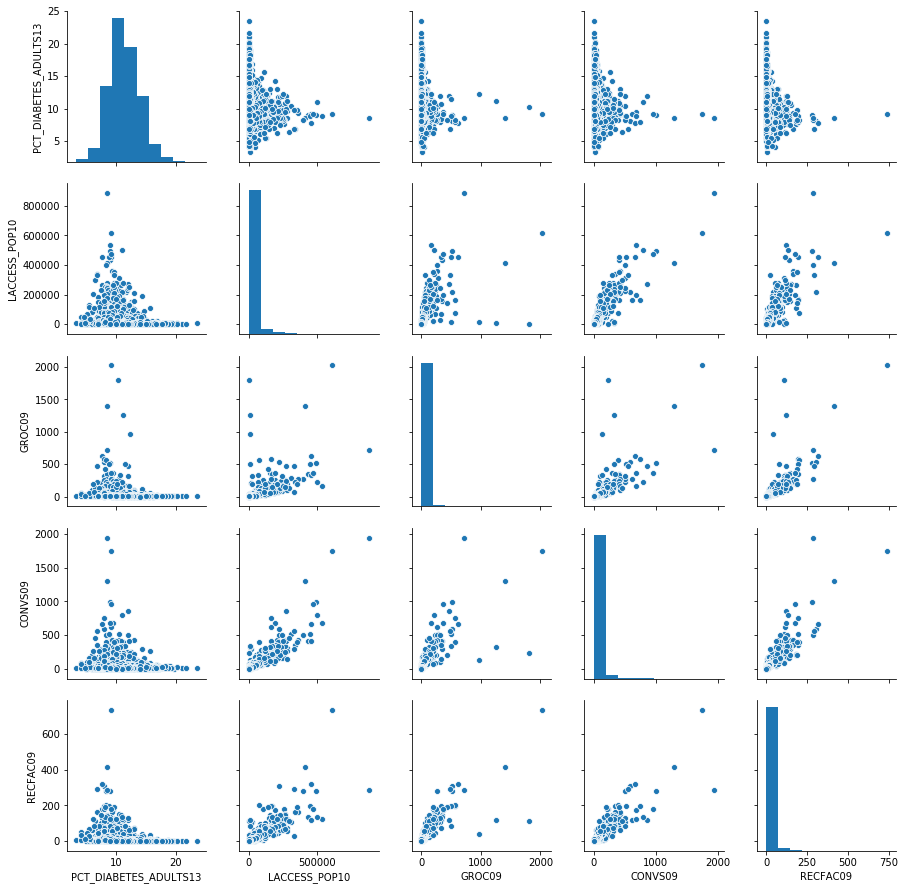

In [15]:
sns.pairplot(df[['PCT_DIABETES_ADULTS13', 'LACCESS_POP10','GROC09',
                 'CONVS09', 'RECFAC09']]);

Total access to stores and number of recreational facilites are very correlated. Low access to stores and the number of grocery stores are very correlated. 

 Dummying the State and County columns before running the model.

In [16]:
df.drop(columns = ['FIPS'], inplace= True)

In [17]:
# checking all variable types are numeric
df.dtypes

State                     object
County                    object
PCT_DIABETES_ADULTS08    float64
PCT_DIABETES_ADULTS13    float64
PCT_OBESE_ADULTS08       float64
PCT_OBESE_ADULTS13       float64
RECFAC09                   int64
LACCESS_POP10            float64
PCT_LACCESS_POP10        float64
LACCESS_LOWI10           float64
PCT_LACCESS_LOWI10       float64
LACCESS_HHNV10           float64
PCT_LACCESS_HHNV10       float64
LACCESS_CHILD10          float64
PCT_LACCESS_CHILD10      float64
LACCESS_SENIORS10        float64
PCT_LACCESS_SENIORS10    float64
GROC09                     int64
GROCPTH09                float64
SUPERC09                   int64
SUPERCPTH09              float64
CONVS09                    int64
CONVSPTH09               float64
SPECS09                    int64
SPECSPTH09               float64
SNAPS12                  float64
SNAPSPTH12               float64
WICS08                     int64
WICS12                     int64
PCH_WICS_08_12           float64
WICSPTH08 

In [18]:
# the two object types
list_of_cols_to_dummy = ['State', 'County']
df = pd.get_dummies(df, columns = list_of_cols_to_dummy, drop_first = True)

### Regression Metrics Function

In [19]:
# a function to calculate the RMSE for all the models I run 
def regression_metrics(y,preds):
    sq_diff = (y-preds)**2 
    # first calc MSE to calc the RMSE
    MSE = metrics.mean_squared_error(y,preds)
    RMSE = np.sqrt(MSE)
    print(f'This is MSE: {MSE}')
    print(f'This is RMSE: {RMSE}')

## Preprocessing

## Train/Test Split and Scale

In [20]:
df.columns

Index(['PCT_DIABETES_ADULTS08', 'PCT_DIABETES_ADULTS13', 'PCT_OBESE_ADULTS08',
       'PCT_OBESE_ADULTS13', 'RECFAC09', 'LACCESS_POP10', 'PCT_LACCESS_POP10',
       'LACCESS_LOWI10', 'PCT_LACCESS_LOWI10', 'LACCESS_HHNV10',
       ...
       'County_Yellow Medicine', 'County_Yellowstone', 'County_Yoakum',
       'County_Yolo', 'County_York', 'County_Young', 'County_Yuba',
       'County_Yuma', 'County_Zapata', 'County_Zavala'],
      dtype='object', length=1814)

In [21]:
#first looking at all the features
#removed convs09 since really correlated variables
X = df.drop(columns = ['PCT_OBESE_ADULTS13', 'CONVS09','PCT_LACCESS_HHNV10','PCT_LACCESS_LOWI10', 'SNAPSPTH12'])

y = df['PCT_OBESE_ADULTS13']

In [22]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .33,
                                                    random_state=22)

In [23]:
#scale the feature
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

The reason we are scaling is to ensure that the regularization term affects the variable in the same way and necessary for both the training and the testing set. It makes sense to scale our data since it contains counts as well as percent change in the dataset.   

# Modelling

## Baseline Model

The baseline is the mean so we compare all the models results to the baseline  $R^2$. There aren't any real outliers, all the values should be considered when evaluating the model. An base mean makes the most sense for this analysis.

In [24]:
# baseline for a linear regression model
#strategy is mean - want to take into account outlier s
base_mean = DummyRegressor(strategy = 'mean')

base_mean.fit(X_train, y_train)

y_hat_base_train = base_mean.predict(X_train)
y_hat_base_test = base_mean.predict(X_test)

In [25]:
base_mean.score(X_train, y_train)

0.0

In [26]:
base_mean.score(X_test, y_test)

-0.0053057969261085525

In [27]:
np.sqrt(mean_squared_error(y_train, y_hat_base_train))

4.520220516824114

In [28]:
np.sqrt(mean_squared_error(y_test, y_hat_base_test))

4.460824953114096

## Linear Regression with all features

We will first run a linear regression on all features. A linear regression established a relationship between the dependent variables and the independent variables using the line of best fit. The best fit is calculated by minimizing the sum of the squares of the deviation from each point to the line.  Linear regression will investigate the relationship between the obesity rate and the independent variables or predictors. 

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
lr.score(X_train, y_train)

0.9224979521807647

In [31]:
lr.score(X_test, y_test)

0.6411221923084469

In [32]:
#prediction made on linear model with all features 
predict_train = lr.predict(X_train)
predict_test = lr.predict(X_test)

In [33]:
#looking at the rmse to compare to the baseline
regression_metrics(y_train,predict_train)

This is MSE: 1.5835523397040934
This is RMSE: 1.2583927605100458


In [34]:
#looking at the rmse to compare the baseline 
regression_metrics(y_test,predict_test)

This is MSE: 7.103604591998342
This is RMSE: 2.665258822703405


The RMSE and $R^2$ are lower than the baseline. A model including all the features is extremely overfit and does not perform well on the testing set. The model suffers from high variance and low bias. Multicollinearity can increase the variance.Below we run a lasso, ridge and  random forest so we can decrease the impact of collinearity between the features. Then we also run a ridge and lasso model to reduce overfitting.  

### Random Forest for important features

The benefits of using Random Forest is that they generalize better and are more accurate. 
Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two - each of them with observations that are more similar among themselves and different from the ones in the other node. Therefore, the importance of each feature is derived from how “pure” each of the nodes is.

In [35]:
#https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
model = RandomForestRegressor(n_estimators = 100)
    
model.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [36]:
#want to create a dataframe of the best features 
model.feature_importances_

array([1.56974630e-02, 8.45567122e-02, 6.53638321e-01, ...,
       3.22170786e-06, 0.00000000e+00, 2.59609822e-07])

In [37]:
features = X_train.columns
#turning the features and score into a dataframe to then plot with score as the feature importance
features_df = pd.DataFrame({'Features': features, 'Score': model.feature_importances_.round(4)})
features_df.sort_values('Score', inplace=True, ascending=False)

#just looking at the top 25 
top_25_rf = features_df['Features'].head(25)

features_df[3:15]

,Features,Score
33,PCT_LOCLFARM12,0.0149
16,CONVSPTH09,0.0127
13,GROCPTH09,0.0112
25,PCH_WICSPTH_08_12,0.0105
23,WICSPTH08,0.0104
32,PCT_LOCLFARM07,0.0101
11,PCT_LACCESS_SENIORS10,0.0087
24,WICSPTH12,0.0085
9,PCT_LACCESS_CHILD10,0.0074
7,LACCESS_HHNV10,0.0072


In [38]:
#turning them into a list to use in the linear regression model
features_RF = list(top_25_rf)

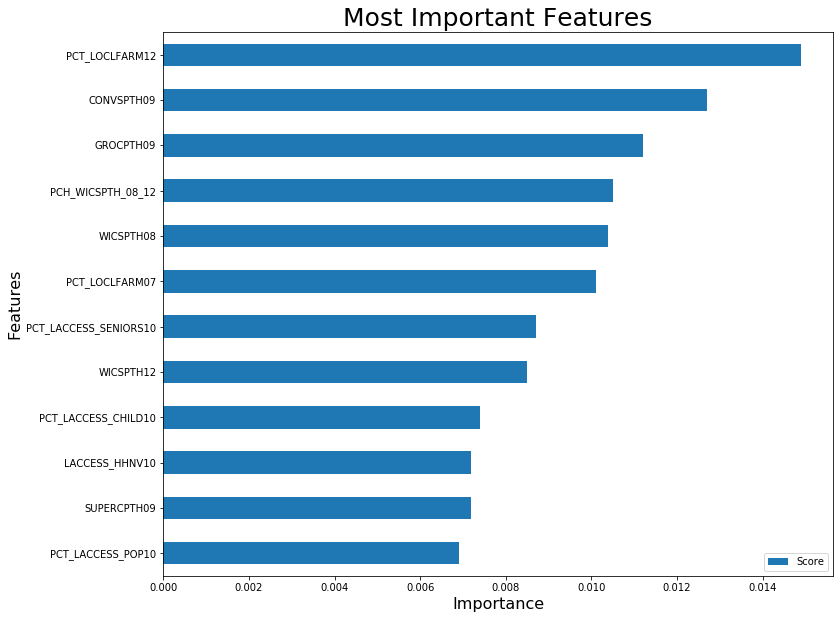

In [39]:
#plotting a bar graph of each feature and their score 
ax = features_df.set_index('Features')[3:15].sort_values(by = 'Score', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set_xlabel('Importance', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16)
ax.invert_yaxis()
plt.title('Most Important Features', fontsize = 25);

The top features based on the importance score is the number of snap affiliated stores, the number of convenience stores, percent of the population with low access and have no car, a number of grocery stores, the number of WICS affiliated stores and the number of the local farmers market. 

## Linear Regression with Random Forest important features

Now we decided to run a linear regression again but with the important feature found above. We expect that this model will not suffer from as much high variance. 

In [40]:
## Scalling of the Random Forest 
# new train test split with random forest features 
X_rf= df[features_RF]
y_rf = df['PCT_OBESE_ADULTS13']

#splitting again 
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, 
                             
                                                    random_state=42)
#scaling with the new x and y 
sc = StandardScaler()
Z_train_rf = sc.fit_transform(X_train_rf)
Z_test_rf = sc.transform(X_test_rf)

In [41]:
lr = LinearRegression()
lr.fit(Z_train_rf, y_train_rf)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
lr.score(Z_train_rf, y_train_rf)

0.7305696029689062

In [43]:
lr.score(Z_test_rf, y_test_rf)

0.72046893480156

In [44]:
#predictions based on linear regression model
predict_train_rf = lr.predict(Z_train_rf)
predict_test_rf = lr.predict(Z_test_rf)

In [45]:
#checking the rmse to the base model 
regression_metrics(y_train_rf,predict_train_rf)

This is MSE: 5.428164817417422
This is RMSE: 2.329842230155815


In [46]:
#checking the rmse to the base model 
regression_metrics(y_test_rf, predict_test_rf)

This is MSE: 5.729347639474209
This is RMSE: 2.3936055730788666


In [47]:
lr.coef_

array([ 2.78180465,  1.51300142, -0.46575737, -0.40612279, -0.15447212,
       -0.09713057, -0.05875445,  0.21849462,  0.18521375, -0.22490912,
        0.03832273,  0.58511866,  0.05469287,  0.13532393, -0.44065318,
        0.07373759,  0.05950946,  0.21976273, -0.02773088,  0.32738922,
       -0.18498229,  0.13470903, -0.12210842, -0.28273639, -0.1797315 ])

In [48]:
lr_df_coeff = pd.DataFrame({
    'column':features_RF,
    'coef': lr.coef_
})

In [49]:
lr_df_coeff.set_index('column', inplace=True)

In [50]:
# creating top features df
Top = lr_df_coeff.head(10)

In [51]:
#creating features with the lowest coefficent df 
bottom = lr_df_coeff.tail(10)

In [52]:
top_bottom = pd.concat([Top, bottom ])

In [53]:
top_bottom.head(10)

,coef
column,
PCT_OBESE_ADULTS08,2.781805
PCT_DIABETES_ADULTS13,1.513001
PCT_DIABETES_ADULTS08,-0.465757
PCT_LOCLFARM12,-0.406123
CONVSPTH09,-0.154472
GROCPTH09,-0.097131
PCH_WICSPTH_08_12,-0.058754
WICSPTH08,0.218495
PCT_LOCLFARM07,0.185214


As the number of convenience stores increased by one, the obesity rate decreased by .103, all else remaining constant. When the number of grocery stores increases by one, the obesity rate will decrease .156, all else remaining constant. This provides evidence that it's hard for people to eat a healthy diet when they don’t have access to it, and this is the main reason why we still have high obesity rates in many parts of the country.

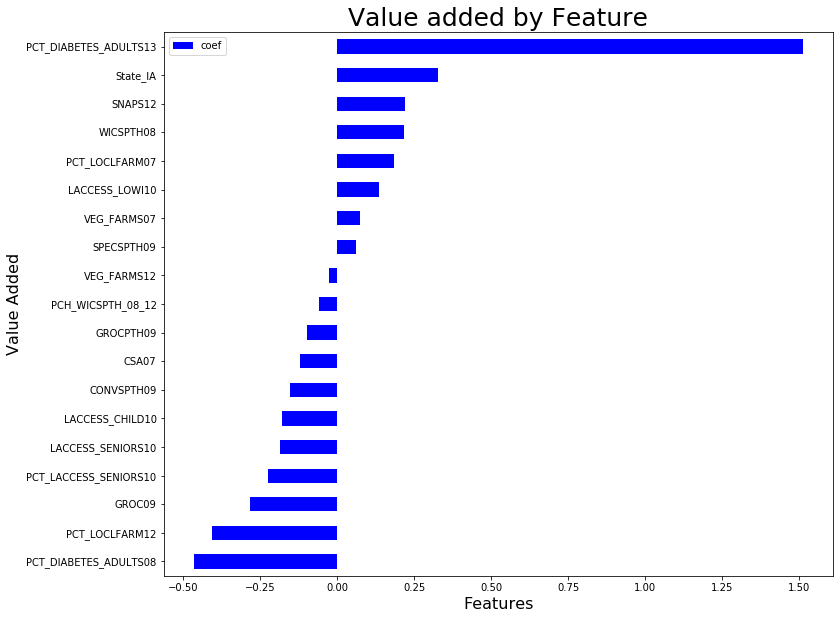

In [54]:
ax = top_bottom.sort_values(by = 'coef', ascending = False)[1:].plot(kind = 'barh', figsize = (12,10), color='blue')
ax.set_xlabel('Features', fontsize = 16)
ax.set_ylabel('Value Added', fontsize = 16)
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

The top features with the largest coefficient and value-added to obesity rate is the percent of access to a local farm, number of WICS affiliated stores per population of 1,000, number of convenience stores per population of 1,000. number of grocery stores per population of 1,000 people, number of SNAP-affiliated stores, percent of people that have no vehicle and low access to the store. 

## Linear Regression with correlated features 

Next we ran another linear regression model but with the correlated features 

In [55]:
# features will be what is correlated to sales price after the feature engineering
correlation = df.corr()[['PCT_OBESE_ADULTS13']]
    
sorted_coefs = abs(correlation).sort_values('PCT_OBESE_ADULTS13', ascending = False)
    
strong_corr = sorted_coefs[(sorted_coefs['PCT_OBESE_ADULTS13'] > .1)]

In [56]:
#correlated features 
strong_corr.drop(['PCT_OBESE_ADULTS13'], axis=1, inplace=True)

/Users/grace1916/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
strong_corr_2 = strong_corr.drop(['PCT_OBESE_ADULTS13'])
#turning the features into a list to then run in the model 
features = list(strong_corr_2.index)

In [58]:
X_corr= df[features]
y_corr= df['PCT_OBESE_ADULTS13']

In [59]:
# a new train_test split based on the correlated features 
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr, y_corr, 
                             
                                                    random_state=42)

In [60]:
lr = LinearRegression()
lr.fit(X_train_corr, y_train_corr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
lr.score(X_train_corr, y_train_corr)

0.7482809072773318

In [62]:
lr.coef_

array([ 6.80939424e-01,  5.79326744e-01, -3.24765496e-01,  1.11788824e-02,
        1.58079202e-01, -1.93567986e+00, -7.49472234e-02, -1.68709494e-02,
        4.33345369e-02,  1.79036793e-02,  1.23556497e-05, -2.78582453e-05,
        8.08201864e-05,  1.79839905e-02,  2.47573925e-02, -2.86247146e+00,
       -1.60180209e-01, -8.87700766e-03,  2.59818894e-03, -6.39280901e-02,
       -5.34331071e-03, -2.18785036e-02, -2.63492007e-01,  1.97039795e-03,
        1.61891321e-04, -3.08942304e-01,  1.20186299e-05,  1.87271009e+00,
       -1.11686378e-03,  1.87292045e+00, -1.20468278e-02,  5.30531242e-03,
       -1.41416765e+00, -2.74922401e+00,  3.03073747e-05,  3.74268336e-02,
       -3.43665566e-02, -1.97671317e-03,  1.60634344e+00, -2.73365378e-02,
        6.87088661e-01, -3.04317384e-01, -7.06906029e-01,  1.68124254e-01,
       -1.78610392e+00, -5.77729504e-01,  1.53211645e-01])

In [63]:
lr.score(X_test_corr, y_test_corr)

0.7307279743788966

In [64]:
lr_train = lr.score(X_train_corr, y_train_corr)
lr_test = lr.score(X_test_corr, y_test_corr)

In [65]:
model_1 = lr.predict(X_train_corr)

In [66]:
model_2 = lr.predict(X_test_corr)

In [67]:
#running the regression_metrics to compare to other models and baseline
regression_metrics(y_train_corr,model_1)

This is MSE: 5.071338416324772
This is RMSE: 2.2519632360064787


In [68]:
#running the regression_metrics to compare to other models and baseline
regression_metrics(y_test_corr,model_2)

This is MSE: 5.51907546759965
This is RMSE: 2.349271263094079


The RMSE better than the baseline but this model did not perform better than the previous model. 

In [69]:
lr.coef_

array([ 6.80939424e-01,  5.79326744e-01, -3.24765496e-01,  1.11788824e-02,
        1.58079202e-01, -1.93567986e+00, -7.49472234e-02, -1.68709494e-02,
        4.33345369e-02,  1.79036793e-02,  1.23556497e-05, -2.78582453e-05,
        8.08201864e-05,  1.79839905e-02,  2.47573925e-02, -2.86247146e+00,
       -1.60180209e-01, -8.87700766e-03,  2.59818894e-03, -6.39280901e-02,
       -5.34331071e-03, -2.18785036e-02, -2.63492007e-01,  1.97039795e-03,
        1.61891321e-04, -3.08942304e-01,  1.20186299e-05,  1.87271009e+00,
       -1.11686378e-03,  1.87292045e+00, -1.20468278e-02,  5.30531242e-03,
       -1.41416765e+00, -2.74922401e+00,  3.03073747e-05,  3.74268336e-02,
       -3.43665566e-02, -1.97671317e-03,  1.60634344e+00, -2.73365378e-02,
        6.87088661e-01, -3.04317384e-01, -7.06906029e-01,  1.68124254e-01,
       -1.78610392e+00, -5.77729504e-01,  1.53211645e-01])

In [70]:
lr_df_coef = pd.DataFrame({
    'column':features,
    'coef': lr.coef_
})

In [71]:
lr_df_coef.set_index('column', inplace=True)

In [72]:
top = lr_df_coef.head(10)
bottom = lr_df_coef.tail(10)

In [73]:
top_bottom = pd.concat([top, bottom], axis=0)

In [74]:
top_bottom.sort_values(by = 'coef', ascending = False)

,coef
column,
State_WV,1.606343
State_OK,0.687089
PCT_OBESE_ADULTS08,0.680939
PCT_DIABETES_ADULTS13,0.579327
State_SC,0.168124
SNAPSPTH12,0.158079
PCT_LACCESS_CHILD10,0.153212
FMRKT09,0.043335
PCT_LOCLFARM07,0.017904


Lifestyle preferences, and food environment play a major role in the rising prevalence of obesity worldwide. There a clear relationship with the area you live in and obesity and studies have shown clusters of high obesity rates in the south. 

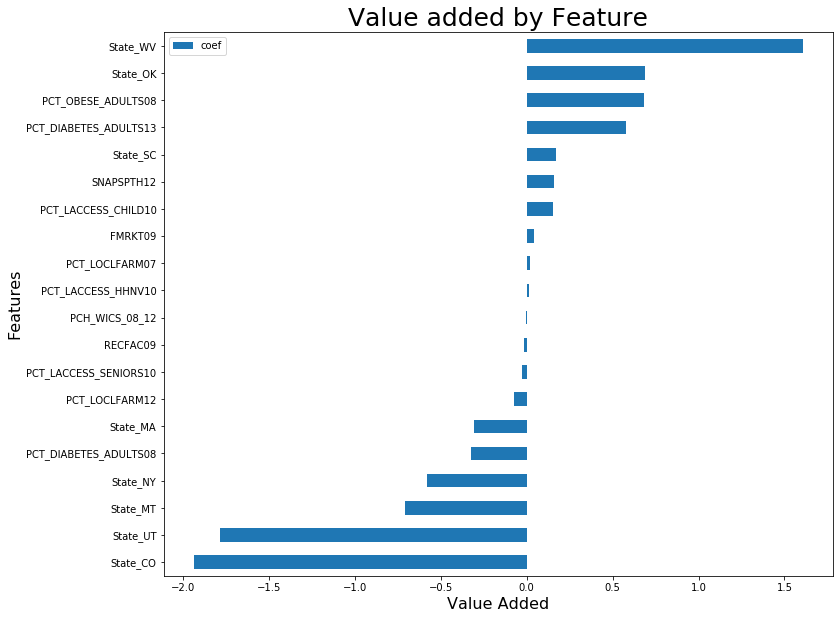

In [75]:
ax = top_bottom.sort_values(by = 'coef', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set_xlabel('Value Added', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16) 
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

The percent of people with low access to stores and no vehicle had an impact on the obesity rate in the state. SNAP affiliated stores was again a top feature to predicting obesity rates. Colorado has the lowest obesity rate among all fifty states. The state of colorado's coefficient is -1.9. This is due to low levels in every demographic category, including age and ethnicity, and a high level of daily physical activity among children and teens.

## Regularized Linear Regression

Lasso, Ridge, and Elastic Net models are forms of regularized linear techniques. Regularized models address the concerns that come up within a model. This includes variance-bias tradeoff, multicollinearity, feature selection, and an interpretation of the output.

#### Ridge

Ridge regression is a technique used when the independent variables are highly correlated. It shrinks the coefficients and it helps to reduce the model complexity and multi-collinearity.

In [76]:
ridge_alphas = [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas = ridge_alphas, scoring = 'r2', cv=5)


# Fit model using best ridge alpha
ridge_cv.fit(Z_train_rf, y_train_rf)

RidgeCV(alphas=array([2.5e+01, 1.0e+01, 4.0e+00, 2.0e+00, 1.0e+00, 8.0e-01, 5.0e-01,
       3.0e-01, 2.0e-01, 1.0e-01, 5.0e-02, 2.0e-02, 1.0e-02]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [77]:
#r2 for train
ridge_cv.score(Z_train_rf, y_train_rf)

0.73033112844062

In [78]:
# r2 for testing 
ridge_cv.score(Z_test_rf, y_test_rf)

0.7211328045952656

In [79]:
ridge_cv.coef_

array([ 2.71246348,  1.45355942, -0.35773862, -0.39380141, -0.1586892 ,
       -0.1038848 , -0.06776154,  0.18866835,  0.1641978 , -0.28592233,
        0.07300147,  0.44055915,  0.05999273,  0.13919946, -0.24254787,
        0.07919074,  0.05277771,  0.18977441, -0.03363986,  0.33159941,
       -0.20824121,  0.1179696 , -0.11734283, -0.26169475, -0.14376664])

In [80]:
#creating variabled to plot in a bar grpah 
ridge_train = ridge_cv.score(Z_train_rf, y_train_rf)
ridge_test = ridge_cv.score(Z_test_rf, y_test_rf)

In [81]:
#predictions based on the ridge 
predict_train = ridge_cv.predict(Z_train_rf)
predict_test = ridge_cv.predict(Z_test_rf)

In [82]:
regression_metrics(y_train_rf,predict_train)

This is MSE: 5.432969320022019
This is RMSE: 2.3308730810625486


In [83]:
regression_metrics(y_test_rf,predict_test)

This is MSE: 5.715740776735055
This is RMSE: 2.390761547443629


In [84]:
ridge_df_coef = pd.DataFrame({
    'column':features_RF,
    'abs_coef': np.abs(ridge_cv.coef_)
})

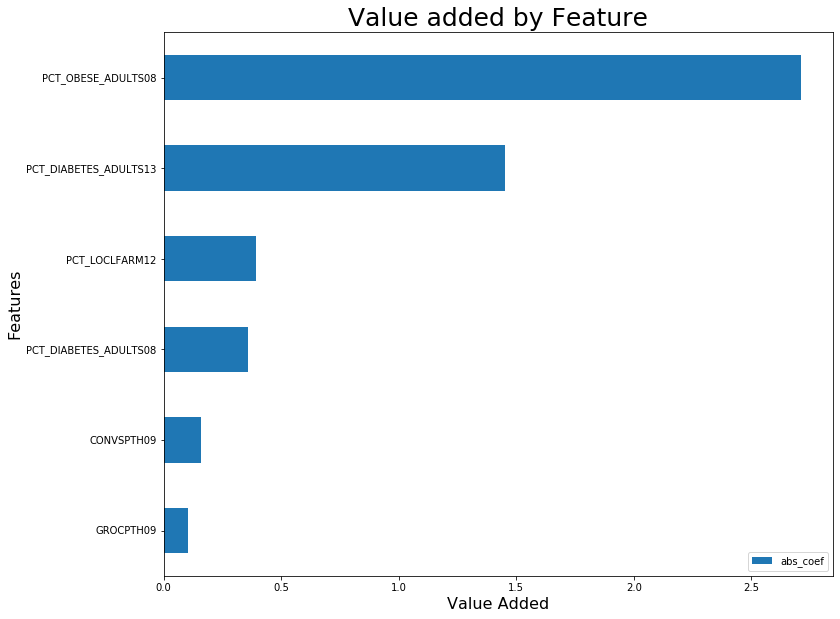

In [85]:
ax = ridge_df_coef.set_index('column').head(6).sort_values(by = 'abs_coef', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set_xlabel('Value Added', fontsize = 16)
ax.set_ylabel('Features', fontsize = 16) 
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

The training and testing scores are very close together, indicating the the model does not suffer from overfitting. The RMSE scores are similar to the linear regression model and better than the baseline. 

#### Lasso

Similar to a ridge, lasso penalizes the absolute size of the regression coefficients. Lasso regression not only helps in reducing over-fitting but it can help us in feature selection. In a Lasso model, the coefficients shrink zero and therefore easier to eliminate some of your input variables as not contributing to the output.

In [86]:
#choosing different alphas to check 
lasso_alphas = [1.0,0.1,0.01,0.001,.00001]

lasso = LassoCV(alphas=lasso_alphas,
               cv=5, max_iter=5000)

# Cross-validate over our list of Lasso alphas.
lasso.fit(Z_train_rf, y_train_rf)

LassoCV(alphas=[1.0, 0.1, 0.01, 0.001, 1e-05], copy_X=True, cv=5, eps=0.001,
        fit_intercept=True, max_iter=5000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [87]:
#r2 for lasso train
lasso.score(Z_train_rf, y_train_rf)

0.7298166768627123

In [88]:
#r2 for lassoo test
lasso.score(Z_test_rf, y_test_rf)

0.7219623143654682

In [89]:
lasso_train = lasso.score(Z_train_rf, y_train_rf)
lasso_test = lasso.score(Z_test_rf, y_test_rf)

In [90]:
pred_train_lasso = lasso.predict(Z_train_rf)
pred_test_lasso = lasso.predict(Z_test_rf)

In [91]:
#going to compare to baseline
regression_metrics(y_train_rf,pred_train_lasso)

This is MSE: 5.443333881653647
This is RMSE: 2.3330953434554806


In [92]:
#going to compare to the baseline 
regression_metrics(y_test_rf,pred_test_lasso)

This is MSE: 5.698738910268234
This is RMSE: 2.387203156471655


In [93]:
lasso_df_coeff = pd.DataFrame({
    'column':features_RF,
    'abs_coef': np.abs(lasso.coef_)
})

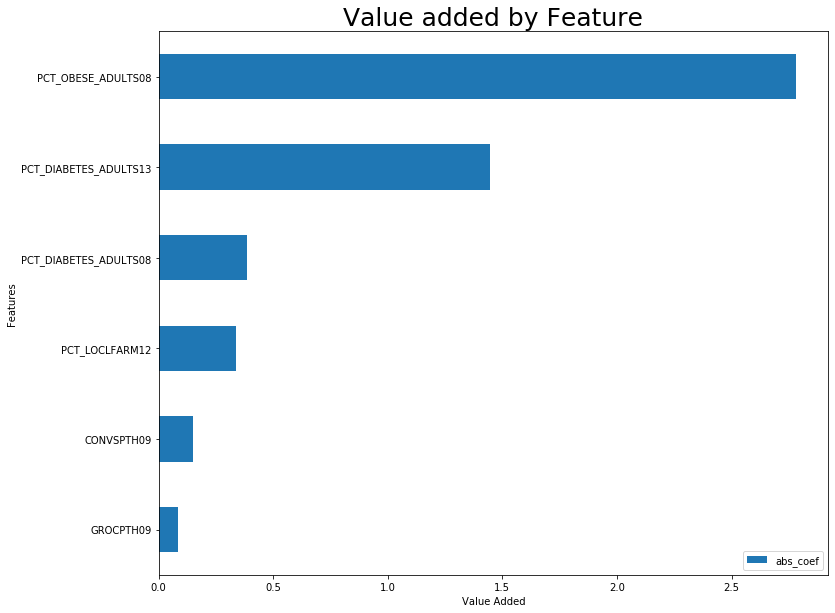

In [94]:
ax = lasso_df_coeff.set_index('column').head(6).sort_values(by = 'abs_coef', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set(xlabel='Value Added', ylabel='Features') 
ax.invert_yaxis()
plt.title('Value added by Feature', fontsize = 25);

Lasso had the best score with train $R^2$ of .73 and testing $R^2$ .73. The model did not suffer from overfitting. The top five features were obese adults, percent of adults with diabetes, percent of local farms, convenience stores and stores affiliates with SNAP. 

### Elastic Net

Elastic net is a hybrid of lasso and ridge regression techniques. We found this technique to be useful in this analysis since multiple features are correlated. 

In [95]:
# list of alphas to check.
alphas = [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]


# Instantiate model
enet = ElasticNetCV(alphas=alphas, l1_ratio=.5, cv=5)


enet = enet.fit(Z_train_rf, y_train_rf)

# predictions
enet_preds = enet.predict(Z_test_rf)
enet_preds_train = enet.predict(Z_train_rf)

# Evaluate model
print(enet.score(Z_train_rf, y_train_rf))
print(enet.score(Z_test_rf, y_test_rf))

0.7302100917504049
0.7217033803478199


In [96]:
#rmse score to compare to other models 
regression_metrics(y_test_rf,enet_preds)

This is MSE: 5.704046095005433
This is RMSE: 2.3883144882961775


In [97]:
#rmse score to compare to other models 
regression_metrics(y_train_rf,enet_preds_train)

This is MSE: 5.435407824031522
This is RMSE: 2.331396110495066


The elastic net had the same results to the lasso model and did not improve passed a testing and training score of .72.

### Random Forest

The benefits of a Random Forest are that it can handle a lot of input variables without variable deletion and it gives estimates of what variables that are important in predicting the target. 

In [98]:
from sklearn.model_selection import GridSearchCV

rf_reg = RandomForestRegressor(max_depth=6,
                              random_state=42,
                              n_estimators=75)

param_grid = {
              "min_samples_leaf": [1, 2, 3, 5, 10]
             }
grid_cv = GridSearchCV(rf_reg, param_grid, cv=5, return_train_score=True)
grid_cv.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=6, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=75, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': [1, 2, 3, 5, 10]},
             pre_dispatch='2*n_jobs', refit=Tr

In [99]:
grid_cv.score(Z_train_rf, y_train_rf)

0.7837318852091488

In [100]:
grid_cv.score(Z_test_rf, y_test_rf)

0.7028902444255394

In [101]:
rf_train = grid_cv.score(Z_train_rf, y_train_rf)
rf_test = grid_cv.score(Z_test_rf, y_test_rf)

In [102]:
pred_train_rf = grid_cv.predict(Z_train_rf)

In [103]:
pred_test_rf = grid_cv.predict(Z_test_rf)

In [104]:
regression_metrics(y_train_rf,pred_train_rf)

This is MSE: 4.357114062751471
This is RMSE: 2.087370130751006


In [105]:
regression_metrics(y_test_rf,pred_test_rf)

This is MSE: 6.089645440863136
This is RMSE: 2.467720697498632


This suffers slight overfitting so we tuned the parameters, we increased the n_estimators and changed the max_depth. The train and testing score stayed the same with .78 on the train and .70 on the testing set. 

### Adaboost on Random Forest

Boosting is a general method for improving the accuracy of any given learning algorithm. Boosting refers to the general problem of producing an accurate prediction by combining rough and moderately inaccurate ones.It combines multiple weak learned into a single strong predictor.

In [106]:
regr = AdaBoostRegressor(random_state=42, n_estimators=100)
regr.fit(Z_train_rf, y_train_rf)
AdaBoostRegressor(n_estimators=100, random_state=42)


AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=100, random_state=42)

In [107]:
#see if it's similar to random forest 
regr.feature_importances_ 

array([0.41281889, 0.23497893, 0.04172281, 0.06325447, 0.01352265,
       0.01648011, 0.00527536, 0.0178322 , 0.01890796, 0.01818697,
       0.00957312, 0.0116412 , 0.00658656, 0.01982433, 0.01514644,
       0.00773191, 0.00985348, 0.01751982, 0.00253684, 0.00256827,
       0.00969136, 0.01043342, 0.00205365, 0.01166627, 0.02019297])

In [108]:
#turning the features and score into a dataframe to then plot 
features_ada_df = pd.DataFrame({'Features': features_RF, 'Score': regr.feature_importances_.round(4)})
features_ada_df.sort_values('Score', inplace=True, ascending=False)

#just looking at the top 25 
top_25_rf = features_ada_df['Features'].head(25)

features_ada_df[3:15]

,Features,Score
2,PCT_DIABETES_ADULTS08,0.0417
24,LACCESS_CHILD10,0.0202
13,SUPERCPTH09,0.0198
8,PCT_LOCLFARM07,0.0189
9,PCT_LACCESS_SENIORS10,0.0182
7,WICSPTH08,0.0178
17,SNAPS12,0.0175
5,GROCPTH09,0.0165
14,PCT_LACCESS_POP10,0.0151
4,CONVSPTH09,0.0135


The important features are again the percent of people with low access to stores, the number of grocery stores and the number of local farms. 

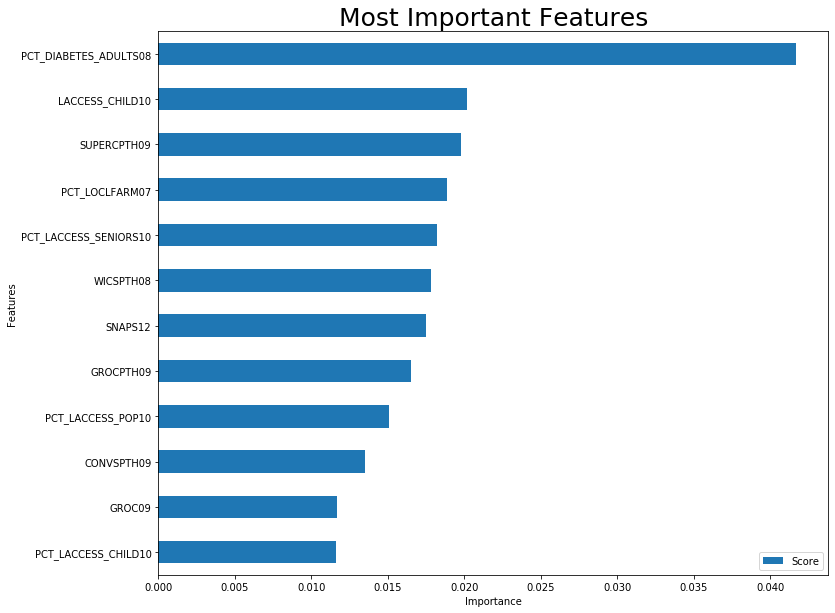

In [109]:
ax = features_ada_df.set_index('Features')[3:15].sort_values(by = 'Score', ascending = False).plot(kind = 'barh', figsize = (12,10))
ax.set(xlabel='Importance', ylabel='Features') 
ax.invert_yaxis()
plt.title('Most Important Features', fontsize = 25);

In [110]:
adaboost_pred_train = regr.predict(Z_train_rf)
adaboost_pred_test = regr.predict(Z_test_rf)

In [111]:
#calculating rmse to compare to other models
regression_metrics(y_train_rf,adaboost_pred_train)

This is MSE: 5.801759941237615
This is RMSE: 2.4086842759559866


In [112]:
#calclulating rmse to comapare to other models 
regression_metrics(y_test_rf,adaboost_pred_test)

This is MSE: 7.009146917616409
This is RMSE: 2.647479351688396


In [113]:
regr.score(Z_train_rf, y_train_rf)

0.712025972492401

In [114]:
regr.score(Z_test_rf, y_test_rf)

0.6580283782197789

In [115]:
ada_train = regr.score(Z_train_rf, y_train_rf)
ada_test = regr.score(Z_test_rf, y_test_rf)

The training and testing score was lower than the random forest and linear regression models. 

### Bar Graph of Scores

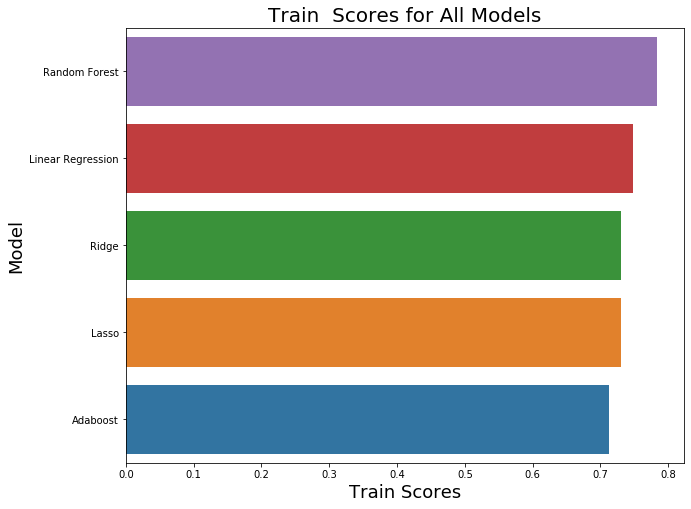

In [116]:
# scores for each model for training set 
scores = [['Linear Regression', lr_train] , ['Lasso', lasso_train], 
        ['Ridge', ridge_train ], ['Random Forest', rf_train], ['Adaboost', ada_train]]
  
#DataFrame to plot 
df_r2 = pd.DataFrame(scores, columns = ['Model', 'R2 Train']).sort_values(by = 'R2 Train')


plt.figure(figsize = (10, 8))
ax = sns.barplot(x='R2 Train', y='Model', data=df_r2)
plt.title('Train  Scores for All Models', size = 20)
ax.invert_yaxis()
plt.xlabel('Train Scores', size = 18)
plt.ylabel('Model', size = 18);

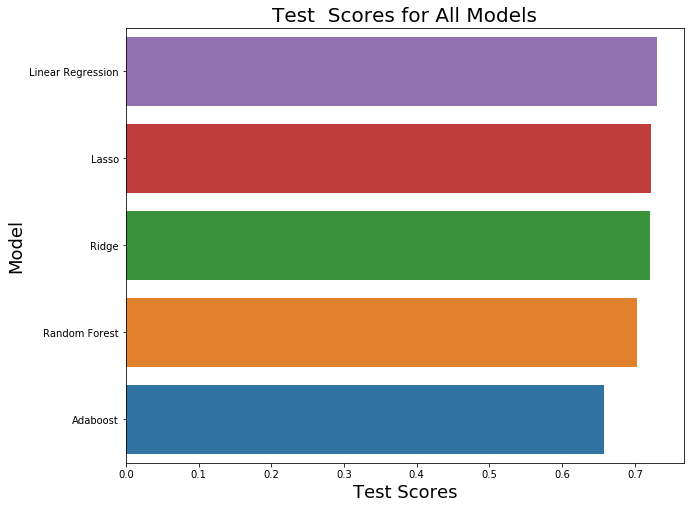

In [117]:
# scores for each model for testing set 
scores = [['Linear Regression', lr_test] , ['Lasso', lasso_test], 
        ['Ridge', ridge_test ], ['Random Forest', rf_test], ['Adaboost', ada_test]]
  
#DataFrame to plot 
df_r2 = pd.DataFrame(scores, columns = ['Model', 'R2 Test']).sort_values(by = 'R2 Test')


plt.figure(figsize = (10, 8))
ax = sns.barplot(x='R2 Test', y='Model', data=df_r2)
ax.invert_yaxis()
plt.title('Test  Scores for All Models', size = 20)
plt.xlabel('Test Scores', size = 18)
plt.ylabel('Model', size = 18);

## Predictions

In [118]:
import statsmodels.api as sm
X = df[features_RF] 
y = df ['PCT_OBESE_ADULTS13']


X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/Users/grace1916/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PCT_OBESE_ADULTS13   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     317.1
Date:                Wed, 11 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:58:13   Log-Likelihood:                -6749.0
No. Observations:                2973   AIC:                         1.355e+04
Df Residuals:                    2947   BIC:                         1.371e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.9329      0.435     11.330      0.000       4.079       5.787
PCT_OBESE_ADULTS08        0.7532      0.020     38.589      0.000       0.715       0.791
PCT_DIABETES_ADULTS13     0.5897      0.036     16.396      0.000       0.519       0.660
PCT_DIABETES_ADULTS08    -0.1967      0.046     -4.235      0.000      -0.288      -0.106
PCT_LOCLFARM12           -0.0463      0.012     -3.740      0.000      -0.071      -0.022
CONVSPTH09               -0.4772      0.181     -2.630      0.009      -0.833      -0.121
GROCPTH09                -0.6711      0.345     -1.944      0.052      -1.348       0.006
PCH_WICSPTH_08_12        -0.0028      0.002     -1.146      0.252      -0.008       0.002
WICSPTH08                 0.5008      0.602      0.832      0.406      -0.680       1.681
PCT_LOCLFARM07            0.0087      0.014      0.642      0.521      -0.018       0.035
PCT_LACCESS_SENIORS10    -0.0519      0.039     -1.318      0.188      -0.129       0.025
WICSPTH12                 0.7752      0.721      1.076      0.282      -0.638       2.188
PCT_LACCESS_CHILD10       0.1113      0.044      2.528      0.012       0.025       0.198
LACCESS_HHNV10         9.591e-05      0.000      0.936      0.349      -0.000       0.000
SUPERCPTH09               7.5464      2.233      3.380      0.001       3.169      11.924
PCT_LACCESS_POP10        -0.0196      0.015     -1.266      0.206      -0.050       0.011
VEG_FARMS07               0.0008      0.003      0.317      0.751      -0.004       0.006
SPECSPTH09                0.8709      0.634      1.374      0.170      -0.372       2.114
SNAPS12                   0.0014      0.001      1.694      0.090      -0.000       0.003
VEG_FARMS12               0.0009      0.003      0.291      0.771      -0.005       0.007
State_IA                  2.0310      0.251      8.096      0.000       1.539       2.523
LACCESS_SENIORS10     -2.858e-05   1.97e-05     -1.450      0.147   -6.72e-05    1.01e-05
LACCESS_LOWI10         4.132e-06   1.09e-05      0.379      0.704   -1.72e-05    2.55e-05
CSA07                    -0.0240      0.010     -2.337      0.020      -0.044      -0.004
GROC09                   -0.0046      0.002     -2.201      0.028      -0.009      -0.001
LACCESS_CHILD10       -1.263e-05   1.31e-05     -0.964      0.335   -3.83e-05    1.31e-05
==============================================================================
Omnibus:                       11.554   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.870
Skew:                           0.128   Prob(JB):                      0.00265
Kurtosis:                       3.173   Cond. No.                     1.13e+06
==============================================================================

The number of grocery stores per population of 1000, the number of convenience store, percent with low access to food stores,the percent of those without a car, the percent of local produce, the availability of vegetable farms, the percent of speciality store all had significant impact on obesity rates.  

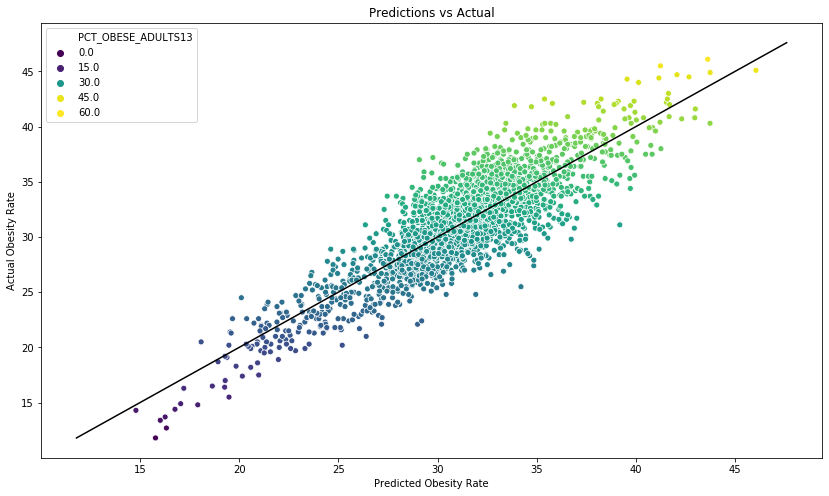

In [120]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(predict_train_rf, y_train_rf, hue=y_train_rf, palette='viridis', legend="brief");
ax.plot([np.min(y), np.max(y)],
         [np.min(y), np.max(y)],
         color = 'black')
ax.set(xlabel="Predicted Obesity Rate", ylabel="Actual Obesity Rate", title="Predictions vs Actual");

### Table of results


|Model                                         | RMSE Train      | RMSE Test      | R2 Train          |  R2 Test  
|-------------------------------------------   |-----------------|----------------|-------------------|----------
| Baseline                                     |      4.48       |      4.46      |   .0              |     -.05
| Linear Regression with all features          |      1.22       |      2.26      |   .92             |      .62
| Linear Regression with Random Forest features|      2.34       |      2.25      |   .75             |      .73
|  Linear Regression with correlated features  |      2.25       |      2.39      |   .73             |      .72
| Ridge                                        |      2.33       |      2.38      |   .73             |      .72
|  Lasso                                       |      2.33       |      2.38      |   .73             |      .72
| Random Forest                                |      2.07       |      2.46      |   .78             |      .71  | Adaboost                                     |      2.70       |      2.45      |   .70             |      .65

# Conclusions and Limitations

This analysis showed how the access to food stores and the number of food stores available is an indicator of obesity rates among adults and found that there is a relationship between access to food stores and obesity among adults. Throughout our analysis, areas with low access to healthy food options tend to have higher adult obesity and diabetes rates. However, the model scores never reached above a .73 on the testing so that provides evidence that these factors are not the only variables affecting obesity. In the U.S., healthier food items tend to be a lot more expensive than unhealthy food items. As a result, even if the counties had a lot of different food options and easy access to healthier food stores, a low-income household will choose the cheapest option and ignore the health consequences.  Some counties had a small number of grocery stores and access to healthy food options, and many households do not have access to a car. The lack of access to supermarkets has a greater chance of health challenges such as diabetes, heart disease, and cancer. Unhealthy food may be a lot cheaper in the short run but there is significant evidence that unhealthy eating will lead to diabetes, cardiovascular disease, and other life-threatening diseases. The consequences, in the long run, are a lot worse. In order to end obesity in the U.S., we need to make healthier food options more affordable. If we were to conduct this study again, we would want to look at the prices of the food items and make interaction terms with the price variables and the store's variables. Prices have a lot of impact on what Americans choose to eat. Therefore, the regression with food prices might have a higher score and show a stronger relationship to the obesity rate in adults. We would also want to analyze changes in the obesity rate within each county and analyze more closely the relationship with the region and obesity rates.

## Sources

Walker, Renee E., Jason Block, and Ichiro Kawachi. "Do Residents of Food Deserts Express Different Food Buying Preferences Compared to Residents of Food Oases? A Mixed-methods Analysis." N.p., 10 Apr. 2012. Web.

Ghosh-Dastidar, B., D. Cohen, G. Hunter, S. N. Zenk, C. Huang, R. Beckman, and T. Dubowitz. "Distance to Store, Food Prices, and Obesity in Urban Food Deserts." N.p., Nov. 2014. Web.

Powell, Lisa M., Sandy Slater, Donka Mirtcheva, Yanjun Bao, and Frank J. Chaloupk. "Food Store Availability and Neighborhood Characteristics in the United States." N.p., 25 Sept. 2006. Web